In [ ]:
# Libraries for working with image processing
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
# Libraries needed to edit/save/watch video clips
from moviepy import editor
import moviepy


In [ ]:
def process_video(test_video, output_video):
	"""
	Read input video stream and produce a video file with detected lane lines.
	Parameters:
		test_video: location of input video file
		output_video: location where output video file is to be saved
	"""
	# read the video file using VideoFileClip without audio
	input_video = editor.VideoFileClip(test_video, audio=False)
	# apply the function "frame_processor" to each frame of the video
	# will give more detail about "frame_processor" in further steps
	# "processed" stores the output video
	processed = input_video.fl_image(frame_processor)
	# save the output video stream to an mp4 file
	processed.write_videofile(output_video, audio=False)


In [ ]:
test_video = "/content/test2.mp4"
output_video = "/content/drive/MyDrive/Colab Notebooks/output_video.mp4"
process_video(test_video, output_video)

Moviepy - Building video /content/drive/MyDrive/Colab Notebooks/output_video.mp4.
Moviepy - Writing video /content/drive/MyDrive/Colab Notebooks/output_video.mp4



t: 100%|█████████▉| 1296/1297 [01:48<00:00, 12.71it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test2.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1295/1298, at time 25.90/25.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Colab Notebooks/output_video.mp4


In [ ]:
def frame_processor(image):
	"""
	Process the input frame to detect lane lines.
	Parameters:
		image: image of a road where one wants to detect lane lines
		(we will be passing frames of video to this function)
	"""
	# convert the RGB image to Gray scale
	grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# applying gaussian Blur which removes noise from the image
	# and focuses on our region of interest
	# size of gaussian kernel
	kernel_size = 5
	# Applying gaussian blur to remove noise from the frames
	blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
	# first threshold for the hysteresis procedure
	low_t = 50
	# second threshold for the hysteresis procedure
	high_t = 150
	# applying canny edge detection and save edges in a variable
	edges = cv2.Canny(blur, low_t, high_t)
	# since we are getting too many edges from our image, we apply
	# a mask polygon to only focus on the road
	# Will explain Region selection in detail in further steps
	region = region_selection(edges)
	# Applying hough transform to get straight lines from our image
	# and find the lane lines
	# Will explain Hough Transform in detail in further steps
	hough = hough_transform(region)
	#lastly we draw the lines on our resulting frame and return it as output
	result = draw_lane_lines(image, lane_lines(image, hough))
	return result



array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
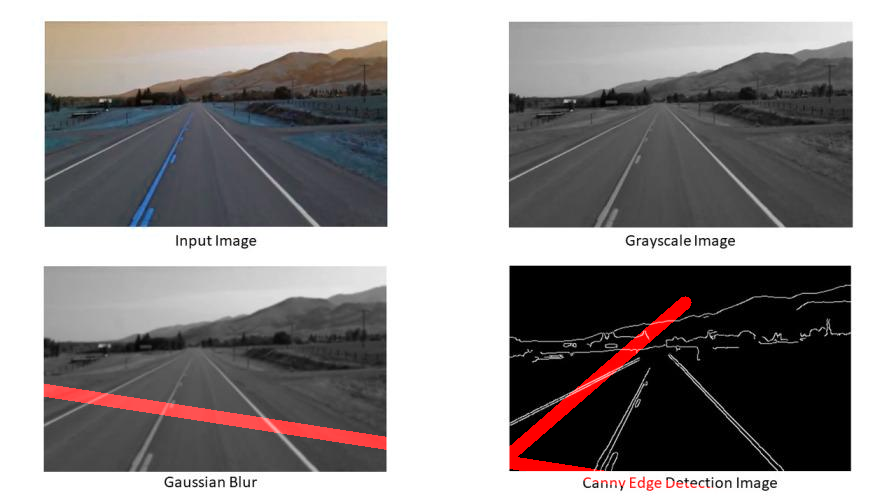

In [ ]:
import cv2

# Load the image
image_path = "/content/input image 1.jpg"
image = cv2.imread(image_path)

# Call the frame_processor function
result = frame_processor(image)
result


In [ ]:
def region_selection(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have
		identified edges in the frame
	"""
	# create an array of the same size as of the input image
	mask = np.zeros_like(image)
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.1, rows * 0.95]
	top_left	 = [cols * 0.4, rows * 0.6]
	bottom_right = [cols * 0.9, rows * 0.95]
	top_right = [cols * 0.6, rows * 0.6]
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image


In [ ]:
def hough_transform(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameter:
		image: grayscale image which should be an output from the edge detector
	"""
	# Distance resolution of the accumulator in pixels.
	rho = 1
	# Angle resolution of the accumulator in radians.
	theta = np.pi/180
	# Only lines that are greater than threshold will be returned.
	threshold = 20
	# Line segments shorter than that are rejected.
	minLineLength = 20
	# Maximum allowed gap between points on the same line to link them
	maxLineGap = 500
	# function returns an array containing dimensions of straight lines
	# appearing in the input image
	return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
						minLineLength = minLineLength, maxLineGap = maxLineGap)


In [ ]:
def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)

	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	#
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full lenght lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness.
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
